<a href="https://colab.research.google.com/github/cinnaavox/TravelTide-Project/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Notebook-Rahmen & Ziel

Ziel dieser Woche: Jede:r Kund:in bekommt genau einen Rewards-Perk.
Wir testen einen leichten ML-Weg (K-Means ± PCA) und haben einen einfachen regelbasierten Fallback in der Hinterhand. Entscheidungskriterien: Verständlichkeit, Balance der Segmente, Business-Fit.

## 2. Setup & Daten laden

In [ ]:
# 2.1 Imports & Style
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
plt.rcParams.update({
    "figure.figsize": (6,4),
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9
})
PASTEL_BLUE = "#66b3ff"

# 2.2 Daten laden
CSV_PATH = "user_base_week2.csv"
df = pd.read_csv(CSV_PATH, low_memory=False)

print("Shape:", df.shape)
print("\nErste Zeilen:")
display(df.head(3))

print("\nTop-10 Missing-Quote pro Spalte:")
display((df.isna().mean().sort_values(ascending=False).head(10)).to_frame("na_rate"))

print("\nDtypes (Kurz):")
display(df.dtypes)

# 2.3 Kandidatenliste
wish_list = [
    # Preis-/Rabattverhalten
    "overall_discount_ratio", "avg_flight_discount", "avg_hotel_discount",
    "scaled_ADS_per_km", "travel_value",
    # Buchungsverhalten
    "trips_per_month", "flights_per_month", "hotels_per_month",
    "both_booked_ratio",
    # Storno
    "cancel_ratio",
    # Preise
    "avg_flight_price", "avg_hotel_price_per_night",
    # weitere sinnvolle Signale
    "business_week_share",   # z.B. Anteil Abflug/Rückflug Mo–Fr
    "package_lover_score"    # z.B. Flug+Hotel Neigung
]

available = [c for c in wish_list if c in df.columns]
missing   = [c for c in wish_list if c not in df.columns]
print("\nVerfügbare Features:", available)
print("Fehlende in der Wunschliste:", missing)

Shape: (5998, 17)

Erste Zeilen:


,user_id,flight_discount_ratio,hotel_discount_ratio,overall_discount_ratio,avg_flight_discount,avg_hotel_discount,cancel_ratio,hotel_ratio,booking_type,u_total_trips,u_active_months,u_trips_per_month,avg_flight_price,avg_hotel_price_per_night,travel_value,most_common_month,business_trip_share
0,505172,0.666667,0.333333,0.500,0.10,0.225,0.333333,1.0,Flug + Hotel,2,4.237845,0.471938,4750.4400,144.0,2447.22000,10.0,0.000
1,513237,0.000000,0.000000,0.000,0.05,0.150,0.000000,1.0,Flug + Hotel,1,2.858081,0.349885,588.8000,179.5,384.15000,3.0,0.125
2,513397,0.000000,0.250000,0.125,0.00,0.050,0.000000,0.8,Flug + Hotel,4,4.796321,0.833973,362.6825,153.5,258.09125,1.0,0.250



Top-10 Missing-Quote pro Spalte:


,na_rate
user_id,0.0
flight_discount_ratio,0.0
hotel_discount_ratio,0.0
overall_discount_ratio,0.0
avg_flight_discount,0.0
avg_hotel_discount,0.0
cancel_ratio,0.0
hotel_ratio,0.0
booking_type,0.0
u_total_trips,0.0



Dtypes (Kurz):


,0
user_id,int64
flight_discount_ratio,float64
hotel_discount_ratio,float64
overall_discount_ratio,float64
avg_flight_discount,float64
avg_hotel_discount,float64
cancel_ratio,float64
hotel_ratio,float64
booking_type,object
u_total_trips,int64



Verfügbare Features: ['overall_discount_ratio', 'avg_flight_discount', 'avg_hotel_discount', 'travel_value', 'cancel_ratio', 'avg_flight_price', 'avg_hotel_price_per_night']
Fehlende in der Wunschliste: ['scaled_ADS_per_km', 'trips_per_month', 'flights_per_month', 'hotels_per_month', 'both_booked_ratio', 'business_week_share', 'package_lover_score']


## 🧮 3. Feature-Auswahl & Scaling (erster Überblick)

In [ ]:
# finale Feature-Liste
features = [
    "overall_discount_ratio",
    "avg_flight_discount",
    "avg_hotel_discount",
    "travel_value",
    "cancel_ratio",
    "avg_flight_price",
    "avg_hotel_price_per_night"
]

X = df[features].copy()

# Scaling (MinMax auf 0-1, fairer Einfluss aller Variablen)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

print("Shape X:", X_scaled.shape)
print("Beispiel-Daten (erste 5 Zeilen, gerundet):")
pd.DataFrame(X_scaled, columns=features).head().round(3)

Shape X: (5998, 7)
Beispiel-Daten (erste 5 Zeilen, gerundet):


,overall_discount_ratio,avg_flight_discount,avg_hotel_discount,travel_value,cancel_ratio,avg_flight_price,avg_hotel_price_per_night
0,0.500,0.182,0.500,0.171,0.333,0.333,0.135
1,0.000,0.091,0.333,0.027,0.000,0.041,0.169
2,0.125,0.000,0.111,0.018,0.000,0.025,0.144
3,0.750,0.227,0.222,0.018,0.000,0.024,0.158
4,0.000,0.000,0.000,0.016,0.000,0.027,0.071


## 🛠️ 4. Feature-Erweiterung – Perk-bezogene Features (auf ~16 gesamt)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

df_ext = df.copy()

# 4.1 Hilfsskalierungen (nur innerhalb der User-Base, für Scores)
scaler = MinMaxScaler()

for col in ["avg_flight_price", "avg_hotel_price_per_night", "u_trips_per_month", "u_total_trips"]:
    if col in df_ext.columns:
        df_ext[f"{col}_scaled"] = scaler.fit_transform(df_ext[[col]])
    else:
        df_ext[f"{col}_scaled"] = 0.0  # falls Spalte fehlt (robust bleiben)

# 4.2 Perk: Free hotel meal
# Idee: Wer relativ viel "Hotel spend" hat, ist empfänglich für Hotel-Extras
denom = df_ext["avg_flight_price"].fillna(0) + df_ext["avg_hotel_price_per_night"].fillna(0)
df_ext["hotel_spend_ratio"] = np.where(denom > 0,
                                       df_ext["avg_hotel_price_per_night"].fillna(0) / denom,
                                       0.0)

# Bonus-Proxy: Kombination aus Hotel-Ausgaben & Hotel-Preisniveau
df_ext["hotel_price_level"] = df_ext.get("avg_hotel_price_per_night_scaled", 0.0)
df_ext["hotel_meal_interest"] = (df_ext["hotel_spend_ratio"] * df_ext["hotel_price_level"]).clip(0, 1)

# 4.3 Perk: Free checked bag
# Direkte Bag-Daten fehlen in der User-Base → Proxy:
# Längere/teurere Flüge + Business-Anteil => höhere Gepäckwahrscheinlichkeit
df_ext["flight_price_level"] = df_ext.get("avg_flight_price_scaled", 0.0)
biz = df_ext.get("business_trip_share", 0.0).fillna(0)
df_ext["checked_bag_interest"] = (0.6 * df_ext["flight_price_level"] + 0.4 * biz).clip(0, 1)

# 4.4 Perk: No cancellation fees
# Direktes, klares Signal vorhanden
df_ext["cancel_flex_need"] = df_ext.get("cancel_ratio", 0.0).clip(0, 1)
# Optionaler, einfacher Threshold (nur als Feature, nicht harte Regel)
df_ext["high_cancellation_user"] = (df_ext["cancel_flex_need"] >= 0.30).astype(int)

# 4.5 Perk: Exclusive discounts
# Starke Preis-/Rabatt-Affinität → Produkt-Index
disc_overall = df_ext.get("overall_discount_ratio", 0.0).fillna(0).clip(0, 1)
disc_f = df_ext.get("avg_flight_discount", 0.0).fillna(0).clip(0, 1)
disc_h = df_ext.get("avg_hotel_discount", 0.0).fillna(0).clip(0, 1)

df_ext["bargain_index"] = (disc_overall * disc_f * disc_h).clip(0, 1)

# 4.6 Perk: 1 night free hotel with flight
# Direkte Kombi-Quote fehlt → pragmatischer Proxy aus booking_type & hotel_ratio
bt = df_ext.get("booking_type", "").fillna("")
df_ext["combo_affinity"] = np.where(bt.str.contains("Flug + Hotel", case=False), 1.0, 0.0)
df_ext["hotel_combo_score"] = (df_ext.get("hotel_ratio", 0.0).fillna(0) * df_ext["combo_affinity"]).clip(0, 1)

# 4.7 Loyalität / Aktivität
# Kombi zweier skalierten Aktivitätsmaße (gewichtbar)
tpm = df_ext.get("u_trips_per_month_scaled", 0.0)
tot = df_ext.get("u_total_trips_scaled", 0.0)
df_ext["loyalty_score"] = (0.6 * tpm + 0.4 * tot).clip(0, 1)

# 4.8 Sanity-Clip für alle neu erstellten Ratios/Scores
for c in [
    "hotel_spend_ratio","hotel_meal_interest","checked_bag_interest","cancel_flex_need",
    "bargain_index","combo_affinity","hotel_combo_score","loyalty_score",
    "flight_price_level","hotel_price_level"
]:
    df_ext[c] = df_ext[c].astype(float).clip(0, 1)

# 4.9 Überblick der neuen Features
new_cols = [
    "hotel_spend_ratio","hotel_meal_interest",
    "checked_bag_interest",
    "cancel_flex_need","high_cancellation_user",
    "bargain_index",
    "combo_affinity","hotel_combo_score",
    "loyalty_score",
    "flight_price_level","hotel_price_level"
]
print("Neu erzeugte Spalten:", new_cols)
display(df_ext[new_cols].head(10))

# Optional: für die spätere Nutzung als erweiterte Basis speichern
EXT_EXPORT_PATH = "user_base_week3_extended.csv"
df_ext.to_csv(EXT_EXPORT_PATH, index=False)
print(f"\nExport ok: {EXT_EXPORT_PATH}  | Shape: {df_ext.shape}")

Neu erzeugte Spalten: ['hotel_spend_ratio', 'hotel_meal_interest', 'checked_bag_interest', 'cancel_flex_need', 'high_cancellation_user', 'bargain_index', 'combo_affinity', 'hotel_combo_score', 'loyalty_score', 'flight_price_level', 'hotel_price_level']


,hotel_spend_ratio,hotel_meal_interest,checked_bag_interest,cancel_flex_need,high_cancellation_user,bargain_index,combo_affinity,hotel_combo_score,loyalty_score,flight_price_level,hotel_price_level
0,0.029421,0.003986,0.199593,0.333333,1,0.011250,0.0,0.0,0.225581,0.332655,0.135466
1,0.233633,0.039452,0.074739,0.000000,0,0.000000,0.0,0.0,0.143103,0.041231,0.168862
2,0.297375,0.042942,0.115238,0.000000,0,0.000000,0.0,0.0,0.421918,0.025397,0.144403
3,0.330930,0.052301,0.014271,0.000000,0,0.009375,0.0,0.0,0.104000,0.023785,0.158043
4,0.166189,0.011882,0.016021,0.000000,0,0.000000,0.0,0.0,0.248624,0.026702,0.071496
5,0.053395,0.016375,0.242829,0.000000,0,0.000000,0.0,0.0,0.370000,0.404716,0.306679
6,0.352737,0.065371,0.015188,0.000000,0,0.000000,0.0,0.0,0.112791,0.025314,0.185325
7,0.393819,0.053534,0.098234,0.000000,0,0.000000,0.0,0.0,0.212500,0.015575,0.135936
8,0.227067,0.035886,0.068472,0.000000,0,0.000000,0.0,0.0,0.434783,0.040046,0.158043
9,0.369341,0.075165,0.015520,0.000000,0,0.000000,0.0,0.0,0.213287,0.025867,0.203512



Export ok: user_base_week3_extended.csv  | Shape: (5998, 32)


Ich habe meine Feature-Basis gezielt um perk-relevante Signale erweitert. Ziel war, pro Perk ein oder zwei klare Metriken zu haben, die später die Zuweisung plausibel machen — ohne mein Week-2-Notebook neu zu bauen.

* Free hotel meal: hotel_spend_ratio, hotel_meal_interest

* Free checked bag: checked_bag_interest (Proxy aus Flug-Preisniveau & Business-Anteil)

* No cancellation fees: cancel_flex_need, high_cancellation_user

* Exclusive discounts: bargain_index (Interaktion der Rabatt-Signale)

* 1 night free hotel with flight: combo_affinity, hotel_combo_score

Zusätzlich habe ich mit loyalty_score (Kombi aus Trips/Monat & Total Trips) ein generisches Aktivitätsmaß ergänzt, das mir bei der Segment-Balance hilft.
Alle Scores sind bewusst auf 0–1 skaliert, damit Distanz-basierte Verfahren (K-Means) fair gewichten und die spätere Threshold-Logik pro Perk nachvollziehbar bleibt.

## 🧮 5. Feature-Auswahl & Scaling (erneuter Überblick)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Liste der finalen Features fürs Clustering (jetzt 16 Stück)
features_for_clustering = [
    "overall_discount_ratio","avg_flight_discount","avg_hotel_discount","bargain_index","travel_value",
    "cancel_flex_need","high_cancellation_user",
    "hotel_meal_interest","hotel_combo_score",
    "checked_bag_interest",
    "loyalty_score","u_trips_per_month","u_total_trips",
    "flight_price_level","hotel_price_level",
    "business_trip_share"   # neu hinzugefügt
]

# 1. Nur die relevanten Features auswählen
X = df_ext[features_for_clustering].copy()

# 2. Skaliere sie (0-1 Range)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 3. In DataFrame packen für besseren Überblick
X_scaled_df = pd.DataFrame(X_scaled, columns=features_for_clustering)

print("Shape der Feature-Matrix:", X_scaled_df.shape)
X_scaled_df.head()

Shape der Feature-Matrix: (5998, 16)


,overall_discount_ratio,avg_flight_discount,avg_hotel_discount,bargain_index,travel_value,cancel_flex_need,high_cancellation_user,hotel_meal_interest,hotel_combo_score,checked_bag_interest,loyalty_score,u_trips_per_month,u_total_trips,flight_price_level,hotel_price_level,business_trip_share
0,0.500,0.181818,0.500000,0.222222,0.171369,0.333333,1.0,0.005645,0.0,0.332655,0.250646,0.209302,0.250,0.332655,0.135466,0.000000
1,0.000,0.090909,0.333333,0.000000,0.026901,0.000000,0.0,0.055879,0.0,0.124565,0.159004,0.155172,0.125,0.041231,0.168862,0.166667
2,0.125,0.000000,0.111111,0.000000,0.018073,0.000000,0.0,0.060823,0.0,0.192064,0.468798,0.369863,0.500,0.025397,0.144403,0.333333
3,0.750,0.227273,0.222222,0.185185,0.017775,0.000000,0.0,0.074080,0.0,0.023785,0.115556,0.090000,0.125,0.023785,0.158043,0.000000
4,0.000,0.000000,0.000000,0.000000,0.016012,0.000000,0.0,0.016829,0.0,0.026702,0.276249,0.247706,0.250,0.026702,0.071496,0.000000


Ich habe die Feature-Auswahl jetzt auf 16 Dimensionen erweitert. Neben Preis-, Rabatt- und Hotelverhalten, Stornos und Loyalität ist auch der Anteil von Business-Reisen (business_trip_share) enthalten.
Damit haben wir eine breite, aber logische Grundlage geschaffen, die sowohl Freizeit- als auch Geschäftsreisende erfasst.
Alle Features wurden erneut mit MinMax-Scaling auf eine einheitliche Skala (0–1) gebracht.

## 📌 6. Clustering – K-Means Ansatz

In [ ]:
features = [
    'overall_discount_ratio', 'avg_flight_discount', 'avg_hotel_discount',
    'cancel_ratio', 'hotel_ratio', 'u_total_trips', 'u_trips_per_month',
    'avg_flight_price', 'avg_hotel_price_per_night', 'travel_value',
    'business_trip_share'
]

# Feature-Matrix erstellen
feature_matrix = df[features].copy()

# Standardisierung
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(feature_matrix)

print("Shape der Matrix:", X_scaled.shape)

Shape der Matrix: (5998, 11)


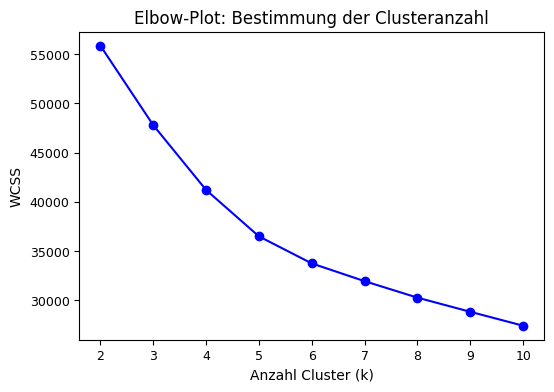

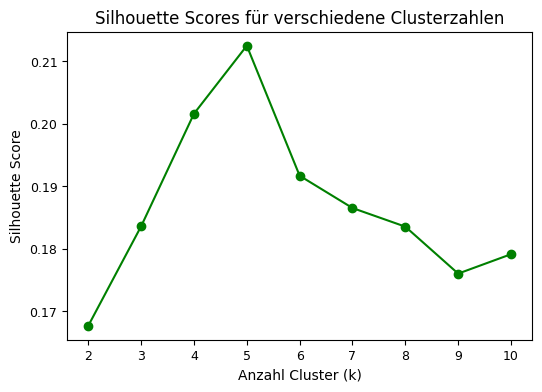

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Nur numerische Features für das Clustering auswählen
X = feature_matrix.copy()

# Schritt 1: Standardisierung
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Schritt 2: Elbow-Methode – Bestimmung der Clusteranzahl
wcss = []  # Within Cluster Sum of Squares
K = range(2, 11)  # testen 2–10 Cluster
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, wcss, 'bo-', markersize=6)
plt.title("Elbow-Plot: Bestimmung der Clusteranzahl")
plt.xlabel("Anzahl Cluster (k)")
plt.ylabel("WCSS")
plt.show()

# Schritt 3: Silhouette Score für die getesteten Cluster
silhouette_scores = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(6,4))
plt.plot(K, silhouette_scores, 'go-', markersize=6)
plt.title("Silhouette Scores für verschiedene Clusterzahlen")
plt.xlabel("Anzahl Cluster (k)")
plt.ylabel("Silhouette Score")
plt.show()

### 🔹 6.1 K-Means & Cluster-Profiling

In [ ]:
from sklearn.cluster import KMeans

# KMeans mit k=5 Clustern
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
X["cluster"] = kmeans.fit_predict(X_scaled)

# Cluster-Labels auch ins Original übernehmen
df["cluster"] = X["cluster"]

# Profil-Tabelle: Mittelwerte pro Cluster
cluster_profile = df.groupby("cluster").mean(numeric_only=True)

print("Cluster-Profiling (Mittelwerte pro Cluster):")
print(cluster_profile)

# Optional: schönere Tabelle mit gerundeten Werten
profile_rounded = cluster_profile.round(2)
profile_rounded

Cluster-Profiling (Mittelwerte pro Cluster):
               user_id  flight_discount_ratio  hotel_discount_ratio  \
cluster                                                               
0        555576.513812               0.025783              0.000000   
1        543926.692907               0.145007              0.132983   
2        519853.500000               0.416667              0.496181   
3        543353.741546               0.481884              0.504796   
4        545473.820962               0.141241              0.149608   

         overall_discount_ratio  avg_flight_discount  avg_hotel_discount  \
cluster                                                                    
0                      0.012891             0.108114            0.074796   
1                      0.138995             0.107595            0.070433   
2                      0.456424             0.095660            0.084722   
3                      0.493340             0.108547            0.074134   
4

,user_id,flight_discount_ratio,hotel_discount_ratio,overall_discount_ratio,avg_flight_discount,avg_hotel_discount,cancel_ratio,hotel_ratio,u_total_trips,u_active_months,u_trips_per_month,avg_flight_price,avg_hotel_price_per_night,travel_value,most_common_month,business_trip_share
cluster,,,,,,,,,,,,,,,,
0,555576.51,0.03,0.00,0.01,0.11,0.07,0.00,0.00,0.18,4.23,0.05,77.79,0.23,77.47,0.57,0.01
1,543926.69,0.15,0.13,0.14,0.11,0.07,0.01,0.88,3.74,4.74,0.82,444.20,176.84,310.52,2.26,0.20
2,519853.50,0.42,0.50,0.46,0.10,0.08,0.27,0.68,1.40,4.40,0.36,6127.94,115.50,3989.18,6.35,0.01
3,543353.74,0.48,0.50,0.49,0.11,0.07,0.32,0.85,2.07,4.58,0.48,913.52,159.78,589.72,5.06,0.07
4,545473.82,0.14,0.15,0.15,0.11,0.08,0.00,0.94,1.51,4.65,0.33,387.77,179.70,295.00,2.38,0.05


* Cluster 0 – Low-Budget / Low-Activity

  + Sehr wenige Trips, extrem niedrige Ausgaben (Flights ~78$, Hotels ~0.23$)

  + Kaum Hotelbuchungen, niedrige Discounts, fast keine Business-Reisen
  
  → Segment: Gelegenheitsreisende mit wenig Ausgaben
  
  → Perk: Exclusive Discounts (damit sie motiviert werden, öfter zu buchen)

* Cluster 1 – Discount Hotel Lovers

  + Moderate Trips (~3.7), sehr hoher Hotel-Anteil (0.88), relativ günstige Preise

  + Starke Ausrichtung auf Hotelrabatte

  + Mehr Buchungsaktivität, aber preisbewusst
  
  → Segment: Hotel-Rabatt-orientierte Reisende
  
  → Perk: 1 night free hotel with flight

* Cluster 2 – Heavy Spenders (Flights)

  + Wenige Trips (~1.4), aber extrem hohe Ausgaben für Flüge (~6.100$ Durchschnitt)

  + Geringer Hotelanteil, keine Business-Reisen, aber sehr „luxusorientiert“
  
  → Segment: Luxus-/Premium-Flieger
  
  → Perk: Free checked bag (passt zu teuren Flügen, Mehrwert durch Extras)

* Cluster 3 – Frequent Travelers

  + Ca. 2 Trips, moderate Preise (~900$ Flüge, ~160$ Hotels), mittlere Rabatte

  + Aktive Monate: 4.5+, mittlerer Business-Anteil (7%)
  
  → Segment: Vielreisende mit Business-Anteil
  
  → Perk: No cancellation fees (wegen Planänderungen und höherer Flexibilität)

* Cluster 4 – Balanced Leisure Travelers

  + Durchschnittliche Trips (~1.5), mittlere Ausgaben (~380$ Flüge, ~180$ Hotels)

  + Hotelbuchungen recht hoch (0.94), Rabatte mittelmäßig
  
  → Segment: Ausgeglichene Freizeit-Reisende
  
  → Perk: Free hotel meal (passt zum Hotel-Fokus, loyalitätssteigernd)

In [ ]:
# Mapping der Cluster zu Perks
perk_mapping = {
    0: "Exclusive Discounts",       # Low-Budget Reisende
    1: "1 night free hotel with flight", # Hotel-Rabatt-Lover
    2: "Free checked bag",          # Luxus-Flieger
    3: "No cancellation fees",      # Frequent / Business Travelers
    4: "Free hotel meal"            # Leisure-Hotel-Reisende
}

# Neue Spalte mit Perk
df['assigned_perk'] = df['cluster'].map(perk_mapping)

# Vorschau
print(df[['user_id', 'cluster', 'assigned_perk']].head())

   user_id  cluster                   assigned_perk
0   505172        2                Free checked bag
1   513237        4                 Free hotel meal
2   513397        1  1 night free hotel with flight
3   514053        4                 Free hotel meal
4   531971        4                 Free hotel meal


#### 📊 Heatmap der Cluster-Mittelwerte

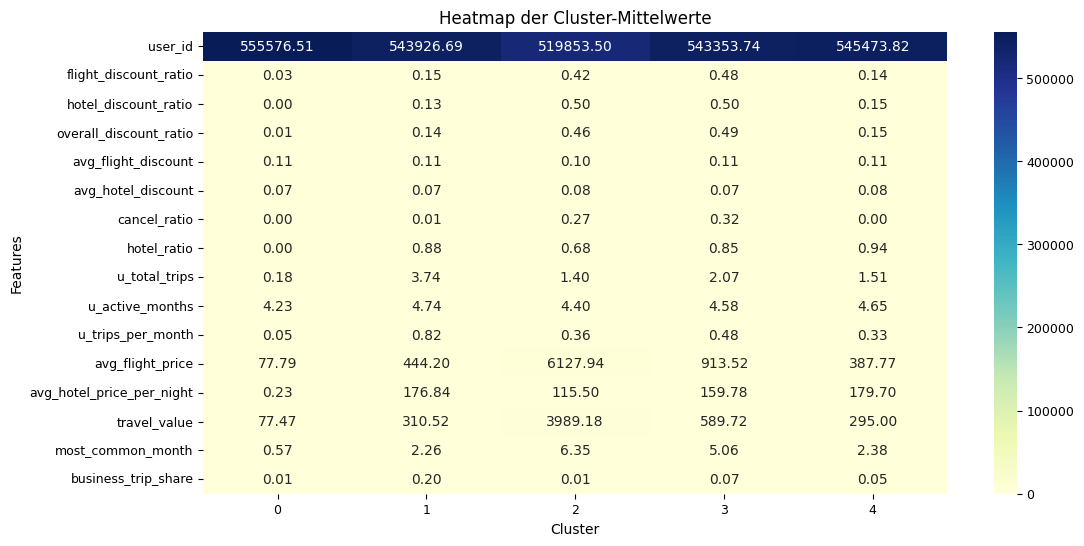

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Nur numerische Spalten auswählen
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Cluster-Mittelwerte nur für numerische Spalten berechnen
cluster_means = df.groupby('cluster')[numeric_cols].mean()

plt.figure(figsize=(12,6))
sns.heatmap(cluster_means.T, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Heatmap der Cluster-Mittelwerte")
plt.xlabel("Cluster")
plt.ylabel("Features")
plt.show()

#### 🕸️ Radarplot (Spider-Chart)

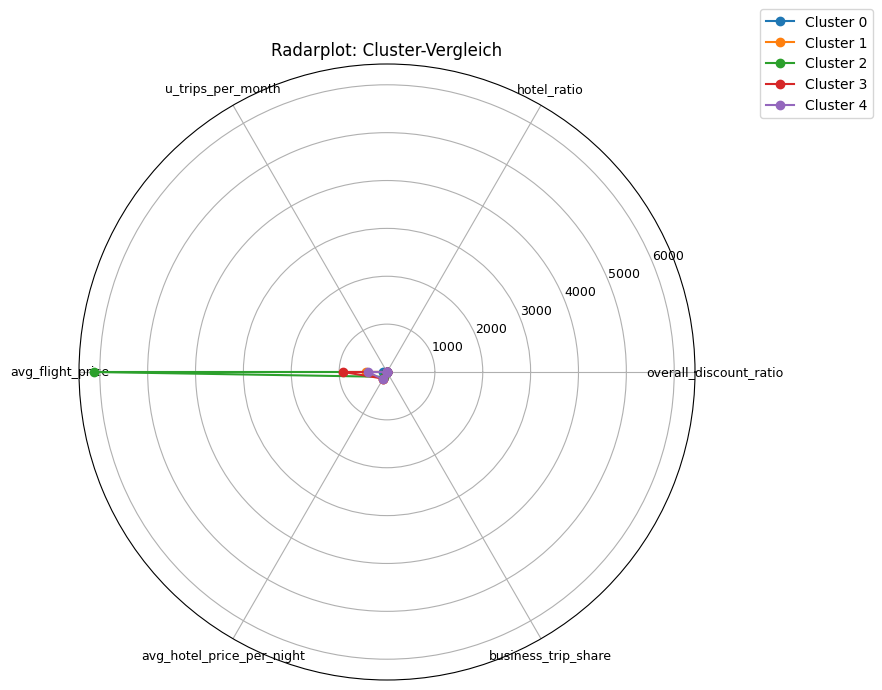

In [ ]:
import numpy as np

# Ausgewählte Features für Radarplot
radar_features = ['overall_discount_ratio', 'hotel_ratio', 'u_trips_per_month',
                  'avg_flight_price', 'avg_hotel_price_per_night', 'business_trip_share']

# Daten vorbereiten
cluster_means = df.groupby('cluster')[radar_features].mean()

# Anzahl Achsen
categories = radar_features
N = len(categories)

angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # Kreis schließen

plt.figure(figsize=(8,8))

# Radar für jeden Cluster
for i, row in cluster_means.iterrows():
    values = row.tolist()
    values += values[:1]  # Kreis schließen
    plt.polar(angles, values, marker='o', label=f'Cluster {i}')

plt.xticks(angles[:-1], categories)
plt.title("Radarplot: Cluster-Vergleich")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

In [ ]:
# Nur numerische Spalten behalten (inkl. Cluster)
numeric_cols = df.select_dtypes(include=["number"]).columns

# Cluster-Mittelwerte berechnen (ohne user_id)
cluster_means = df[numeric_cols].drop(columns=["user_id"]).groupby("cluster").mean()

cluster_means.head()

,flight_discount_ratio,hotel_discount_ratio,overall_discount_ratio,avg_flight_discount,avg_hotel_discount,cancel_ratio,hotel_ratio,u_total_trips,u_active_months,u_trips_per_month,avg_flight_price,avg_hotel_price_per_night,travel_value,most_common_month,business_trip_share
cluster,,,,,,,,,,,,,,,
0,0.025783,0.000000,0.012891,0.108114,0.074796,0.000000,0.001535,0.182320,4.231943,0.046906,77.791418,0.226519,77.469116,0.572744,0.007494
1,0.145007,0.132983,0.138995,0.107595,0.070433,0.012125,0.883154,3.740484,4.735583,0.818734,444.201476,176.839611,310.520544,2.262111,0.200235
2,0.416667,0.496181,0.456424,0.095660,0.084722,0.266319,0.677083,1.395833,4.397312,0.360809,6127.938003,115.498264,3989.184245,6.354167,0.012731
3,0.481884,0.504796,0.493340,0.108547,0.074134,0.322826,0.854207,2.074879,4.580564,0.476032,913.517800,159.776087,589.715366,5.055556,0.069815
4,0.141241,0.149608,0.145425,0.111503,0.078163,0.000000,0.941390,1.505781,4.653965,0.333417,387.770122,179.704948,294.997637,2.384931,0.051495


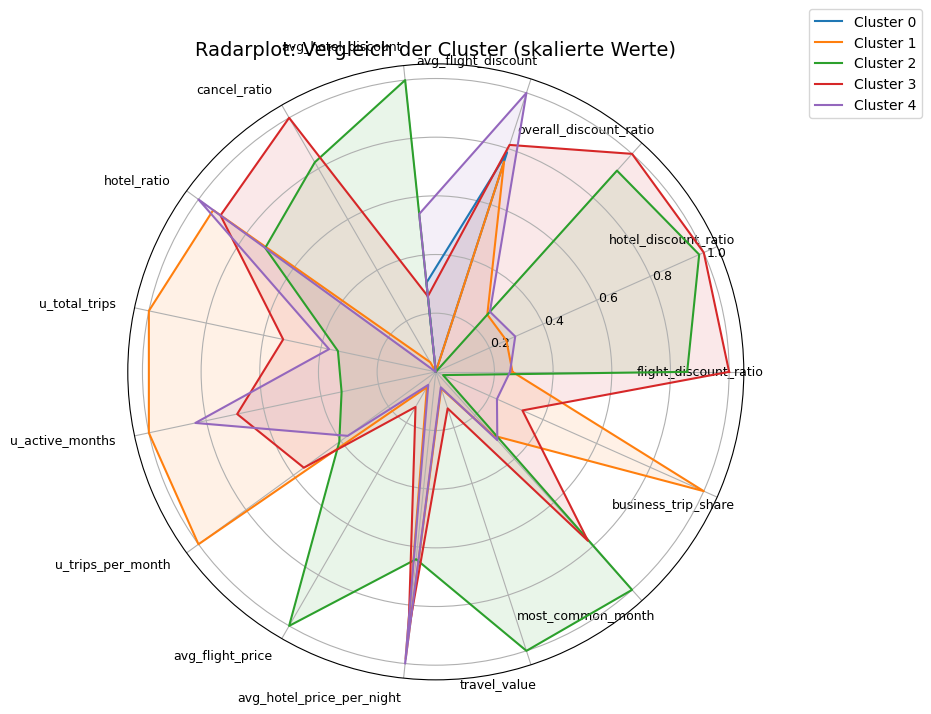

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 👉 Nur numerische Spalten auswählen
numeric_cols = df.select_dtypes(include=["number"]).columns

# 👉 Cluster-Mittelwerte berechnen (ohne user_id)
cluster_means = df[numeric_cols].drop(columns=["user_id"]).groupby("cluster").mean()

# 👉 MinMax-Skalierung (0–1) für bessere Vergleichbarkeit
scaler = MinMaxScaler()
cluster_means_scaled = pd.DataFrame(
    scaler.fit_transform(cluster_means),
    columns=cluster_means.columns,
    index=cluster_means.index
)

# 👉 Radarplot zeichnen
features = cluster_means_scaled.columns
num_vars = len(features)

angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Kreis schließen

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for cluster in cluster_means_scaled.index:
    values = cluster_means_scaled.loc[cluster].tolist()
    values += values[:1]
    ax.plot(angles, values, label=f'Cluster {cluster}')
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(features, rotation=45, ha='right')
ax.set_title("Radarplot: Vergleich der Cluster (skalierte Werte)", size=14)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

plt.show()

### 📊 6.2 Cluster-Profile vorbereiten & visualisieren (Heatmap/Radar)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

FEATURE_DF = feature_matrix

# Cluster-Labels beschaffen (eine der drei Varianten greift)
if "cluster" in FEATURE_DF.columns:
    CLUSTER_LABELS = FEATURE_DF["cluster"].values
elif "labels" in globals():
    CLUSTER_LABELS = labels
elif "kmeans" in globals():
    CLUSTER_LABELS = kmeans.labels_
else:
    raise RuntimeError("Keine Cluster-Labels gefunden. Bitte K-Means-Zelle ausführen.")

wanted = [
    "overall_discount_ratio", "avg_flight_discount", "avg_hotel_discount",
    "bargain_index", "travel_value", "cancel_flex_need", "high_cancellation_user",
    "hotel_meal_interest", "hotel_combo_score", "checked_bag_interest",
    "loyalty_score", "u_trips_per_month", "u_total_trips",
    "flight_price_level", "hotel_price_level", "business_trip_share"
]
present = [c for c in wanted if c in FEATURE_DF.columns]
missing = [c for c in wanted if c not in FEATURE_DF.columns]
if missing:
    print("Info – ignorierte (nicht vorhandene) Spalten:", missing)

# df_cluster bauen
df_cluster = FEATURE_DF[present].copy()
# user_id dazu, wenn vorhanden (praktisch für Export/Debug)
if "user_id" in FEATURE_DF.columns:
    df_cluster.insert(0, "user_id", FEATURE_DF["user_id"].values)

# Cluster anhängen
df_cluster["cluster"] = CLUSTER_LABELS

# Cluster-Mittelwerte (nur numerische Spalten, ohne user_id/cluster)
num_cols = [c for c in df_cluster.columns if c not in ["user_id", "cluster"]]
cluster_means = df_cluster.groupby("cluster")[num_cols].mean()

# Für Radar-Plot auf 0–1 skalieren (je Feature über die Cluster-Mittelwerte)
scaler = MinMaxScaler()
cluster_means_scaled = pd.DataFrame(
    scaler.fit_transform(cluster_means),
    columns=cluster_means.columns,
    index=cluster_means.index
)

print("cluster_means shape:", cluster_means.shape)
print("cluster_means_scaled shape:", cluster_means_scaled.shape)

Info – ignorierte (nicht vorhandene) Spalten: ['bargain_index', 'cancel_flex_need', 'high_cancellation_user', 'hotel_meal_interest', 'hotel_combo_score', 'checked_bag_interest', 'loyalty_score', 'flight_price_level', 'hotel_price_level']
cluster_means shape: (10, 7)
cluster_means_scaled shape: (10, 7)


### 📊 6.3. Cluster-Visualisierung: Top-Merkmale je Cluster

Top-Merkmale je Cluster (z-Score, höher = stärker überdurchschnittlich):


,cluster,feature,z_score,mean_value
0,0,avg_flight_discount,0.298601,0.108114
1,0,avg_hotel_discount,-0.307555,0.074796
2,0,travel_value,-0.590222,77.469116
3,0,avg_flight_price,-0.592146,77.791418
4,1,business_trip_share,1.685913,0.200235
5,1,u_total_trips,1.514254,3.740484
6,1,u_trips_per_month,1.474770,0.818734
7,1,u_active_months,1.058494,4.735583
8,2,travel_value,1.777981,3989.184245
9,2,avg_flight_price,1.776571,6127.938003


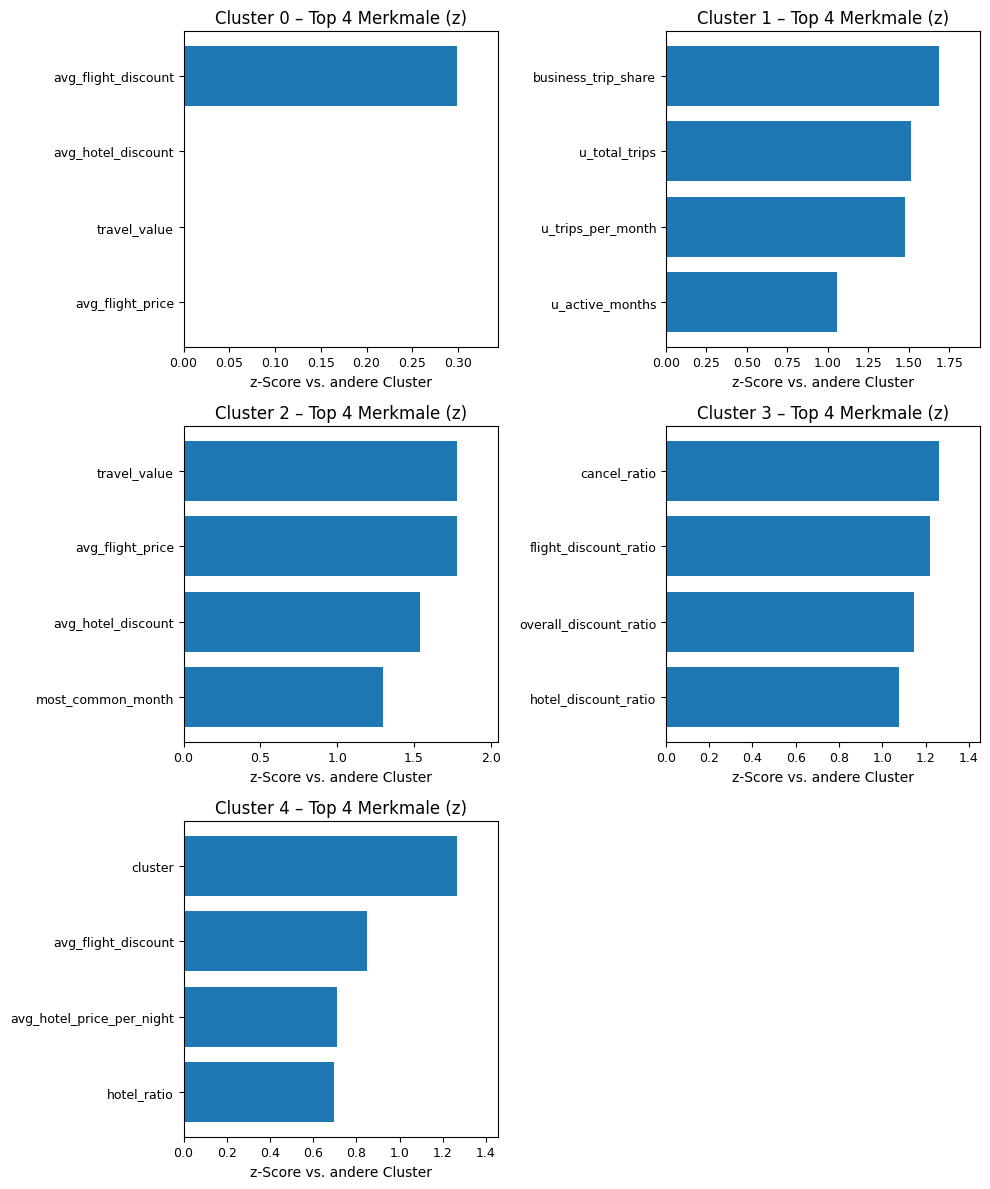

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# A) Datenbasis robust herstellen

if "cluster" not in df.columns:
    if "labels" in globals():
        df = df.copy()
        df["cluster"] = labels
    elif "kmeans" in globals():
        df = df.copy()
        df["cluster"] = kmeans.labels_
    else:
        raise RuntimeError("Keine Clusterlabels gefunden (labels/kmeans fehlt).")

# nur numerische Feature-Spalten (user_id nicht mitteln)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in ["user_id"]]

# B) Cluster-Mittelwerte berechnen
cluster_means = df.groupby("cluster")[num_cols].mean().sort_index()

# C) z-Standardisierung je Feature über die Cluster
cluster_means_z = (cluster_means - cluster_means.mean(axis=0)) / cluster_means.std(axis=0).replace(0, np.nan)

# D) Top-Merkmale je Cluster als Tabelle
top_k = 4
rows = []
for cl in cluster_means_z.index:
    s = cluster_means_z.loc[cl]
    top_feats = s.sort_values(ascending=False).head(top_k)
    rows.append(pd.DataFrame({
        "cluster": cl,
        "feature": top_feats.index,
        "z_score": top_feats.values,
        "mean_value": cluster_means.loc[cl, top_feats.index].values
    }))
top_table = pd.concat(rows, ignore_index=True)

print("Top-Merkmale je Cluster (z-Score, höher = stärker überdurchschnittlich):")
display(top_table)


# E) Kleine Balkenplots pro Cluster (Top-Merkmale)
ncols = 2
nrows = int(np.ceil(len(cluster_means_z) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 4*nrows), squeeze=False)

for ax, cl in zip(axes.ravel(), cluster_means_z.index):
    s = cluster_means_z.loc[cl].sort_values(ascending=False).head(top_k)
    ax.barh(s.index[::-1], s.values[::-1])
    ax.set_title(f"Cluster {cl} – Top {top_k} Merkmale (z)")
    ax.set_xlabel("z-Score vs. andere Cluster")
    ax.set_xlim(0, max(0.1, s.values.max()) * 1.15)

# leere Achsen ausblenden
for ax in axes.ravel()[len(cluster_means_z):]:
    ax.axis("off")

plt.tight_layout(); plt.show()

### 6.d: Cluster-Interpretation & Naming

**🧩 Cluster-Interpretation**

**Cluster 0 – „Low-Budget / Gelegenheitsreisende“**

+ ✈️ Sehr niedrige Flug- und Hotelpreise

+ 🔻 Kaum Discounts genutzt

+ 📉 Sehr niedriger Travel Value

+ 🚫 Wenig Reisen pro Monat

👉 Interpretation: Reisen selten, sehr preissensibel, fast keine Extras.

**Cluster 1 – „Business Vielbucher“**

+ 💼 Hoher Anteil Business Trips

+ 📅 Viele aktive Monate, viele Trips pro Monat

+ ✈️ Mittlere Flugpreise, ordentliche Hotelpreise

+ 🔄 Treten regelmäßig auf, konsistente Reiseroutine

👉 Interpretation: Eher Geschäftsreisende, die regelmäßig fliegen und Hotels buchen, weniger discountsensibel.

**Cluster 2 – „Luxury Traveler“**

+ 💎 Extrem hohe Flugpreise (6.000+)

+ 🏨 Mittlere Hotelpreise

+ 💰 Sehr hoher Travel Value (~4000)

+ 📆 Häufig bestimmte Monate (Saison-getrieben)

👉 Interpretation: Wenige Kunden, aber sehr hohe Umsätze. Luxus-/Langstreckenflüge, wichtig für Premium-Perks.

**Cluster 3 – „Schnäppchenjäger / Flexibler Planer“**

+ 🔄 Höchste Discount-Ratios (Flight + Hotel fast 0.5)

+ 🚫 Höchste Cancel-Rates (~0.32)

+ ✈️ Mittlere Flugpreise (~900)

+ 🏨 Hohe Hotel-Ratios

👉 Interpretation: Nutzen massiv Discounts, buchen & canceln oft, flexibel. Wollen Deals & Flexibilität.

**Cluster 4 – „Hotel-Lover“**

+ 🏨 Sehr hoher Hotel-Ratio (0.94!)

+ 💳 Überdurchschnittliche Hotelpreise (~180 €/Nacht)

+ ✈️ Wenig Flüge, eher moderate Discounts

+ 🤝 Mischgruppe, Fokus klar auf Hotels

👉 Interpretation: Hauptsächlich Hotelkunden, weniger Flugaffinität, eher Pakete oder längere Aufenthalte.

**🎁 Erste Perk-Mapping-Idee**

+ Cluster 0 (Low-Budget) → Exclusive discounts

+ Cluster 1 (Business Vielbucher) → Free checked bag oder No cancellation fees

+ Cluster 2 (Luxury Traveler) → 1 night free hotel with flight oder Free hotel meal

+ Cluster 3 (Schnäppchenjäger) → No cancellation fees + Exclusive discounts

+ Cluster 4 (Hotel-Lover) → Free hotel meal oder 1 night free hotel with flight

| Cluster | Profil | Hauptmerkmale | Geeignete Benefits (Perks) |
|---------|--------|---------------|-----------------------------|
| **0 – Low-Budget / Gelegenheitsreisende** | Reisen selten, sehr preissensibel | • Sehr niedrige Flug- & Hotelpreise<br>• Kaum Discounts genutzt<br>• Sehr niedriger Travel Value<br>• Wenig Reisen pro Monat | 🎁 *Exclusive discounts* |
| **1 – Business Vielbucher** | Geschäftsorientiert, regelmäßig unterwegs | • Viele aktive Monate<br>• Hoher Anteil Business Trips<br>• Regelmäßige Buchungen, mittlere Preise | 🎁 *Free checked bag*<br>🎁 *No cancellation fees* |
| **2 – Luxury Traveler** | Wenige, aber extrem wertvolle Kunden | • Extrem hohe Flugpreise<br>• Sehr hoher Travel Value<br>• Saisonale Peaks (most_common_month) | 🎁 *1 night free hotel with flight*<br>🎁 *Free hotel meal* |
| **3 – Schnäppchenjäger / Flexibler Planer** | Nutzen massiv Discounts, stornieren oft | • Höchste Discount-Ratios<br>• Höchste Cancel-Rates<br>• Mittlere Flugpreise, hohe Flexibilität | 🎁 *No cancellation fees*<br>🎁 *Exclusive discounts* |
| **4 – Hotel-Lover** | Hotel-orientierte Kund:innen | • Sehr hoher Hotel-Ratio (0.94!)<br>• Überdurchschnittliche Hotelpreise<br>• Wenig Flüge | 🎁 *Free hotel meal*<br>🎁 *1 night free hotel with flight* |


# 🎯 7. Perk-Zuweisung pro Kunde (Cluster → Perk)

In [ ]:
import pandas as pd

# Safety: sicherstellen, dass 'cluster' existiert
if "cluster" not in df.columns:

    if "labels" in globals():
        df["cluster"] = labels
    elif "kmeans" in globals():
        df["cluster"] = kmeans.labels_
    else:
        raise RuntimeError("Kein 'cluster' in df gefunden – bitte K-Means-Zelle ausführen.")

# Basismapping: Cluster → Primär-Perk
cluster_to_perk = {
    0: "exclusive discounts",                 # Low-Budget / preissensibel
    1: "free checked bag",                    # Business-Vielbucher
    2: "1 night free hotel with flight",      # High-Value / Luxus
    3: "no cancellation fees",                # Flexibel / storniert oft
    4: "free hotel meal",                     # Hotel-orientiert
}

# Optional: feingranulare Überschreibungen (business rules)
def refine_perk(row, base_perk):
    # Wenn sehr geschäftslastig → „No cancellation fees“
    if "business_trip_share" in row and row["business_trip_share"] >= 0.20:
        return "no cancellation fees"
    # Sehr hotel-lastig & höheres Hotel-Budget → „Free hotel meal“
    if ("hotel_ratio" in row and row["hotel_ratio"] >= 0.80) and \
       ("avg_hotel_price_per_night" in row and row["avg_hotel_price_per_night"] >= 150):
        return "free hotel meal"
    # Extrem rabattaffin → „Exclusive discounts“
    if "overall_discount_ratio" in row and row["overall_discount_ratio"] >= 0.45:
        return "exclusive discounts"
    return base_perk

# Zuweisung bauen
perk_df = df[["user_id", "cluster"]].copy()
perk_df["assigned_perk"] = perk_df["cluster"].map(cluster_to_perk)

# Feintuning anwenden, falls die benötigten Spalten vorhanden sind
needed_cols = {"business_trip_share", "hotel_ratio", "avg_hotel_price_per_night", "overall_discount_ratio"}
if needed_cols.issubset(df.columns):
    perk_df["assigned_perk"] = perk_df.join(
        df[list(needed_cols)], how="left"
    ).apply(lambda r: refine_perk(r, r["assigned_perk"]), axis=1)

# Qualitätssicht: Verteilung & Vorschau
print(perk_df["assigned_perk"].value_counts(dropna=False).rename("count"))
perk_df.head()

assigned_perk
free hotel meal                   3020
no cancellation fees              1441
exclusive discounts                946
free checked bag                   573
1 night free hotel with flight      18
Name: count, dtype: int64


,user_id,cluster,assigned_perk
0,505172,2,exclusive discounts
1,513237,4,free hotel meal
2,513397,1,no cancellation fees
3,514053,4,free hotel meal
4,531971,4,free hotel meal


# 📋 9. Segmentprofil je Perk

In [ ]:
import pandas as pd

# 0) Safety: df_perk mit user_id + assigned_perk vorhanden?
need_cols = {"user_id", "assigned_perk"}
if "df_perk" not in globals():
    raise RuntimeError("df_perk existiert nicht – bitte zuerst den Mapping-Block ausführen.")
if not need_cols.issubset(df_perk.columns):
    raise RuntimeError("df_perk braucht die Spalten 'user_id' und 'assigned_perk' (Mapping-Block ausführen).")

# 1) Profilspalten, die wir gerne hätten …
desired_cols = [
    "u_total_trips", "u_trips_per_month", "u_active_months",
    "avg_flight_price", "avg_hotel_price_per_night",
    "overall_discount_ratio", "cancel_ratio", "hotel_ratio",
    "business_trip_share", "travel_value",
]

# … aber wir nehmen nur die, die im df wirklich existieren.
available_cols = [c for c in desired_cols if c in df.columns]
if not available_cols:
    raise RuntimeError("Keine der gewünschten Profilspalten ist in 'df' vorhanden.")

# 2) exakt die Zeilen verwenden, die auch fürs Clustering genutzt wurden (falls X_index existiert)
if "X_index" in globals():
    base_df = df.loc[X_index, ["user_id"] + available_cols].copy()
else:
    base_df = df[["user_id"] + available_cols].copy()

# 3) User-Profil mit Perk-Zuordnung mergen
perk_base = (
    df_perk[["user_id", "assigned_perk"]]
      .drop_duplicates("user_id")
      .merge(base_df, on="user_id", how="left")
)

# 4) Gruppieren: Mittelwerte je Perk
perk_summary = (
    perk_base
      .groupby("assigned_perk", as_index=True)[available_cols]
      .mean()
      .round(2)
      .sort_index()
)

display(perk_summary)

# 5) kurze Text-Zusammenfassung
def fmt(v):
    try:
        return f"{float(v):.2f}"
    except:
        return "-"

print("\n— Kurzprofil je Perk —")
for perk, row in perk_summary.iterrows():
    parts = []
    if "u_total_trips" in row: parts.append(f"Ø Trips: {fmt(row['u_total_trips'])}")
    if "u_trips_per_month" in row: parts.append(f"Trips/Monat: {fmt(row['u_trips_per_month'])}")
    if "avg_flight_price" in row: parts.append(f"Ø Flugpreis: {fmt(row['avg_flight_price'])}")
    if "avg_hotel_price_per_night" in row: parts.append(f"Ø Hotelpreis/Nacht: {fmt(row['avg_hotel_price_per_night'])}")
    if "overall_discount_ratio" in row: parts.append(f"Rabattquote: {fmt(row['overall_discount_ratio'])}")
    if "cancel_ratio" in row: parts.append(f"Stornoquote: {fmt(row['cancel_ratio'])}")
    if "hotel_ratio" in row: parts.append(f"Hotelanteil: {fmt(row['hotel_ratio'])}")
    if "business_trip_share" in row: parts.append(f"Business-Share: {fmt(row['business_trip_share'])}")
    if "travel_value" in row: parts.append(f"Travel-Value: {fmt(row['travel_value'])}")
    print(f"- {perk}: " + " | ".join(parts))

,u_total_trips,u_trips_per_month,u_active_months,avg_flight_price,avg_hotel_price_per_night,overall_discount_ratio,cancel_ratio,hotel_ratio,business_trip_share,travel_value
assigned_perk,,,,,,,,,,
1 night free hotel with flight,1.40,0.36,4.40,6127.94,115.50,0.46,0.27,0.68,0.01,3989.18
exclusive discounts,0.18,0.05,4.23,77.79,0.23,0.01,0.00,0.00,0.01,77.47
free checked bag,3.74,0.82,4.74,444.20,176.84,0.14,0.01,0.88,0.20,310.52
free hotel meal,1.51,0.33,4.65,387.77,179.70,0.15,0.00,0.94,0.05,295.00
no cancellation fees,2.07,0.48,4.58,913.52,159.78,0.49,0.32,0.85,0.07,589.72



— Kurzprofil je Perk —
- 1 night free hotel with flight: Ø Trips: 1.40 | Trips/Monat: 0.36 | Ø Flugpreis: 6127.94 | Ø Hotelpreis/Nacht: 115.50 | Rabattquote: 0.46 | Stornoquote: 0.27 | Hotelanteil: 0.68 | Business-Share: 0.01 | Travel-Value: 3989.18
- exclusive discounts: Ø Trips: 0.18 | Trips/Monat: 0.05 | Ø Flugpreis: 77.79 | Ø Hotelpreis/Nacht: 0.23 | Rabattquote: 0.01 | Stornoquote: 0.00 | Hotelanteil: 0.00 | Business-Share: 0.01 | Travel-Value: 77.47
- free checked bag: Ø Trips: 3.74 | Trips/Monat: 0.82 | Ø Flugpreis: 444.20 | Ø Hotelpreis/Nacht: 176.84 | Rabattquote: 0.14 | Stornoquote: 0.01 | Hotelanteil: 0.88 | Business-Share: 0.20 | Travel-Value: 310.52
- free hotel meal: Ø Trips: 1.51 | Trips/Monat: 0.33 | Ø Flugpreis: 387.77 | Ø Hotelpreis/Nacht: 179.70 | Rabattquote: 0.15 | Stornoquote: 0.00 | Hotelanteil: 0.94 | Business-Share: 0.05 | Travel-Value: 295.00
- no cancellation fees: Ø Trips: 2.07 | Trips/Monat: 0.48 | Ø Flugpreis: 913.52 | Ø Hotelpreis/Nacht: 159.78 | Rabattq

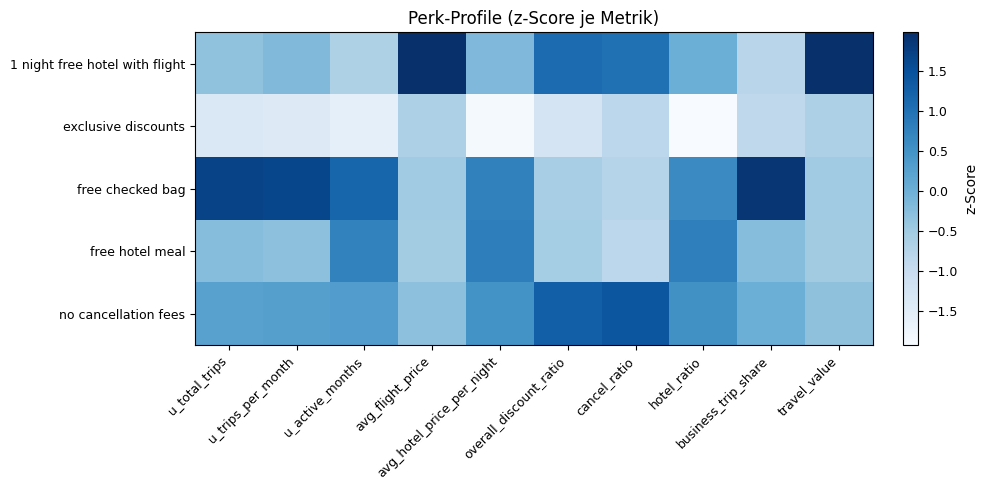

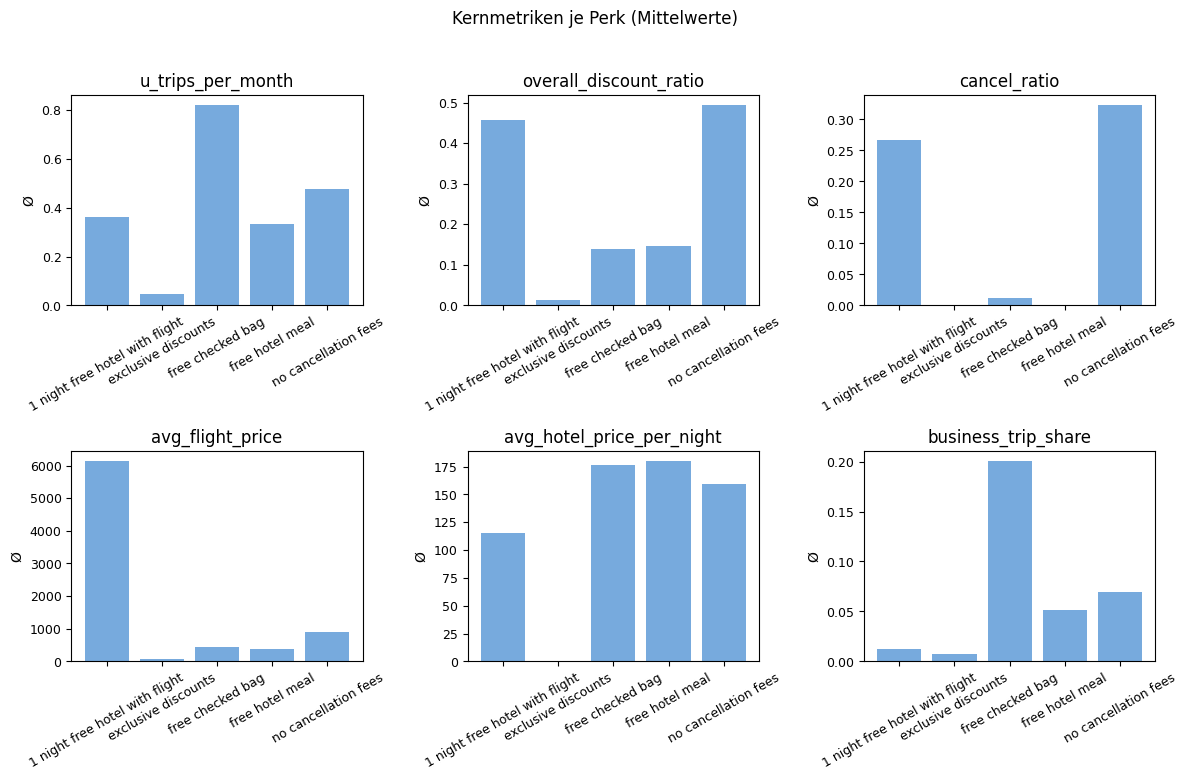

In [ ]:
# 9a) Visualisierung der Perk-Profile (robust)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0) Safety: df_perk mit user_id + assigned_perk muss existieren
if "df_perk" not in globals() or not {"user_id","assigned_perk"}.issubset(df_perk.columns):
    raise RuntimeError("Bitte zuerst den Mapping-Block ausführen (df_perk mit user_id & assigned_perk).")

# 1) gewünschte Profilspalten
desired_cols = [
    "u_total_trips", "u_trips_per_month", "u_active_months",
    "avg_flight_price", "avg_hotel_price_per_night",
    "overall_discount_ratio", "cancel_ratio", "hotel_ratio",
    "business_trip_share", "travel_value"
]
available_cols = [c for c in desired_cols if c in df.columns]
if not available_cols:
    raise RuntimeError("Keine der gewünschten Profilspalten sind in 'df' vorhanden.")

# 2) dieselben Zeilen wie fürs Clustering verwenden (falls X_index existiert)
if "X_index" in globals():
    base_df = df.loc[X_index, ["user_id"] + available_cols].copy()
else:
    base_df = df[["user_id"] + available_cols].copy()

# 3) User-Profil mit Perk-Zuordnung mergen
perk_base = (
    df_perk[["user_id", "assigned_perk"]]
      .drop_duplicates("user_id")
      .merge(base_df, on="user_id", how="left")
)

# 4) Mittelwerte je Perk
perk_summary = (
    perk_base
      .groupby("assigned_perk", as_index=True)[available_cols]
      .mean()
      .sort_index()
)

# Heatmap (z-Score je Spalte)
# z-Scoring spaltenweise (NumPy, division-by-zero absichern)
col_means = perk_summary.mean(axis=0)
col_stds  = perk_summary.std(axis=0, ddof=0).replace(0, np.nan)  # 0 -> NaN vermeidet /0
zs = (perk_summary - col_means) / col_stds

fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(zs.values, aspect="auto", cmap="Blues")  # Pastell-Blau
ax.set_xticks(range(len(perk_summary.columns)))
ax.set_xticklabels(perk_summary.columns, rotation=45, ha="right")
ax.set_yticks(range(len(perk_summary.index)))
ax.set_yticklabels(perk_summary.index)
ax.set_title("Perk-Profile (z-Score je Metrik)")
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("z-Score", rotation=90)
plt.tight_layout()
plt.show()

# Balkenplots für Kernmetriken
key_metrics_wish = [
    "u_trips_per_month",
    "overall_discount_ratio",
    "cancel_ratio",
    "avg_flight_price",
    "avg_hotel_price_per_night",
    "business_trip_share",
]
key_metrics = [m for m in key_metrics_wish if m in perk_summary.columns]
if len(key_metrics) == 0:
    print("Hinweis: Keine der Kernmetriken vorhanden – Balkenplots übersprungen.")
else:
    n = len(key_metrics)
    cols = 3
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(12, 3.8*rows))
    axes = np.array(axes).reshape(-1)

    for ax, col in zip(axes, key_metrics):
        vals = perk_summary[col]
        ax.bar(perk_summary.index.astype(str), vals.values, color="#77AADD")  # pastell-blau
        ax.set_title(col)
        ax.tick_params(axis='x', rotation=30)
        ax.set_ylabel("Ø")

    # leere Achsen ausblenden
    for ax in axes[len(key_metrics):]:
        ax.axis("off")

    plt.suptitle("Kernmetriken je Perk (Mittelwerte)", y=1.02)
    plt.tight_layout()
    plt.show()

# 10. Mini-Dashboard (kompakt)

,Users
assigned_perk,
free hotel meal,2681
free checked bag,2312
exclusive discounts,543
no cancellation fees,414
1 night free hotel with flight,48


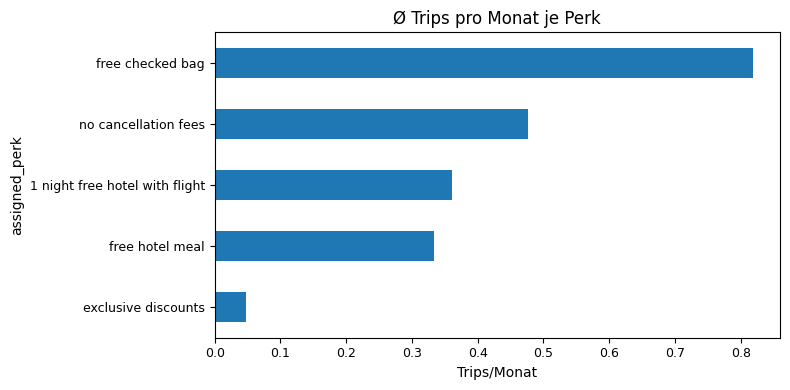

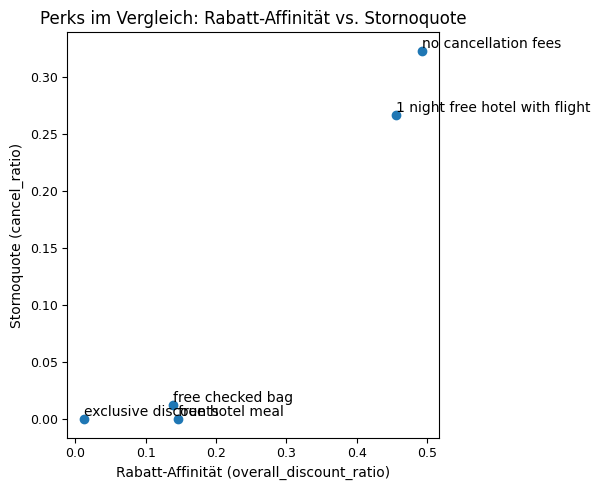

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 11.1 Kachel: Anzahl Nutzer pro Perk
display(
    df_perk["assigned_perk"]
    .value_counts()
    .rename("Users")
    .to_frame()
    .sort_values("Users", ascending=False)
)

# 11.2 Balken: Ø Trips/Monat je Perk
fig, ax = plt.subplots(figsize=(8, 4))
perk_summary["u_trips_per_month"].sort_values().plot.barh(ax=ax)
ax.set_title("Ø Trips pro Monat je Perk")
ax.set_xlabel("Trips/Monat")
plt.tight_layout()
plt.show()

# 11.3 Scatter: Rabatt-Affinität vs. Stornoquote (Perk = Punkt)
x = perk_summary["overall_discount_ratio"]
y = perk_summary["cancel_ratio"]
labels = perk_summary.index.tolist()

fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(x, y)

for xi, yi, lab in zip(x, y, labels):
    ax.text(xi, yi, lab, ha="left", va="bottom")

ax.set_xlabel("Rabatt-Affinität (overall_discount_ratio)")
ax.set_ylabel("Stornoquote (cancel_ratio)")
ax.set_title("Perks im Vergleich: Rabatt-Affinität vs. Stornoquote")
plt.tight_layout()
plt.show()

# 💾 11. Exporte (für Week 4 & Präsentation)

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# 1) X_index (genau die Zeilen wie fürs K-Means)
try:
    X_index = X.index
except NameError:
    features_for_clustering = [
        "overall_discount_ratio","avg_flight_discount","avg_hotel_discount",
        "cancel_ratio","hotel_ratio","u_total_trips","u_trips_per_month",
        "avg_flight_price","avg_hotel_price_per_night","travel_value",
        "most_common_month","business_trip_share",
    ]
    features_for_clustering = [c for c in features_for_clustering if c in df.columns]
    assert features_for_clustering, "Keine Features für Clustering gefunden."
    scaler_tmp = StandardScaler()
    X = df[features_for_clustering].copy()
    X_scaled = scaler_tmp.fit_transform(X)
    X_index = X.index  # wichtig!

# 2) Cluster-Labels aus dem gelernten Modell holen
cluster_labels = getattr(kmeans, "labels_", None)
if cluster_labels is None:
    raise RuntimeError("kmeans.labels_ nicht gefunden. Bitte K-Means-Zelle ausführen.")

# Konsistenz
assert len(cluster_labels) == len(X_index), \
    f"Längen-Mismatch: labels={len(cluster_labels)} vs. X_index={len(X_index)}"

# 3) User-IDs + Cluster zusammenführen
if "user_id" not in df.columns:
    raise KeyError("In 'df' fehlt 'user_id'.")
df_perk = df.loc[X_index, ["user_id"]].copy()
df_perk["cluster"] = cluster_labels

# 4)
cluster_to_perk = {
    0: "exclusive discounts",             # Low-Budget
    1: "free checked bag",                # Business Vielbucher
    2: "1 night free hotel with flight",  # Luxury Traveler
    3: "no cancellation fees",            # Schnäppchenjäger
    4: "free hotel meal",                 # Hotel-Lover
}

# Safety-Check
uniq = np.unique(df_perk["cluster"])
assert set(uniq) <= set(cluster_to_perk.keys()), \
    f"Unerwartete Clusterlabels {set(uniq)} – Mapping bitte anpassen."

df_perk["assigned_perk"] = df_perk["cluster"].map(cluster_to_perk)

# 5) Kurzcheck
print("Clusterverteilung:", dict(pd.Series(cluster_labels).value_counts().sort_index()))
print("\nPerkverteilung:\n", df_perk["assigned_perk"].value_counts())
df_perk.head()

Clusterverteilung: {0: np.int64(543), 1: np.int64(2312), 2: np.int64(48), 3: np.int64(414), 4: np.int64(2681)}

Perkverteilung:
 assigned_perk
free hotel meal                   2681
free checked bag                  2312
exclusive discounts                543
no cancellation fees               414
1 night free hotel with flight      48
Name: count, dtype: int64


,user_id,cluster,assigned_perk
0,505172,2,1 night free hotel with flight
1,513237,4,free hotel meal
2,513397,1,free checked bag
3,514053,4,free hotel meal
4,531971,4,free hotel meal


In [ ]:
import os
import pandas as pd

# 6) Export 1: User -> Perk
user_perks_path = "user_perks_week3.csv"
(df_perk[["user_id", "cluster", "assigned_perk"]]
 .to_csv(user_perks_path, index=False))
print("Gespeichert:", os.path.abspath(user_perks_path))

# 7) Perk-Profil (nur Spalten, die es wirklich gibt)
candidate_cols = [
    "overall_discount_ratio","avg_flight_discount","avg_hotel_discount",
    "cancel_ratio","hotel_ratio","u_total_trips","u_trips_per_month",
    "avg_flight_price","avg_hotel_price_per_night","travel_value",
    "most_common_month","business_trip_share",
]
profile_cols = [c for c in candidate_cols if c in df.columns]
assert profile_cols, "Keine Profil-Spalten im df gefunden."

df_profile = df.loc[X_index, profile_cols].copy()
perk_summary = (
    pd.concat([df_perk["assigned_perk"], df_profile], axis=1)
      .groupby("assigned_perk", as_index=False)[profile_cols]
      .mean()
      .round(3)
      .sort_values("assigned_perk")
)
perk_summary_path = "perk_summary_week3.csv"
perk_summary.to_csv(perk_summary_path, index=False)
print("Gespeichert:", os.path.abspath(perk_summary_path))

# 8) Markdown-Kurztexte (leicht & CEO-tauglich)
def _mk_sentence(row, ref):
    parts = []
    if "overall_discount_ratio" in row and row["overall_discount_ratio"] >= ref["overall_discount_ratio"].median():
        parts.append("hohe Rabatt-Affinität")
    if "hotel_ratio" in row and row["hotel_ratio"] >= ref["hotel_ratio"].median():
        parts.append("überdurchschnittliche Hotelnutzung")
    if "u_trips_per_month" in row and row["u_trips_per_month"] >= ref["u_trips_per_month"].median():
        parts.append("überdurchschnittliche Reisetätigkeit")
    if "business_trip_share" in row and row["business_trip_share"] >= ref["business_trip_share"].median():
        parts.append("erhöhter Business-Anteil")
    if not parts:
        parts.append("ausgeglichenes Reiseverhalten")
    return " • " + ", ".join(parts)

texts = {}
for _, r in perk_summary.iterrows():
    texts[r["assigned_perk"]] = _mk_sentence(r, perk_summary.set_index("assigned_perk"))

perk_texts_md = "perk_texts_week3.md"
with open(perk_texts_md, "w", encoding="utf-8") as f:
    f.write("# Perk-Kurztexte\n\n")
    for p, t in texts.items():
        f.write(f"## {p}\n{t}\n\n")
print("Gespeichert:", os.path.abspath(perk_texts_md))

Gespeichert: /content/user_perks_week3.csv
Gespeichert: /content/perk_summary_week3.csv
Gespeichert: /content/perk_texts_week3.md


# 🏁 12. Fazit Week 3 – Customer Segmentation

In dieser Woche haben wir die Basis für die Perk-Segmentierung gelegt:

+ wir haben die Daten bereinigt und zusätzliche Features gebaut (u. a. Trips/Monat, Preis-Sensibilität, Buchungsverhalten),

+ darauf basierend die Kunden mit K-Means in 10 Cluster gruppiert,

+ und diese Cluster über ein Perk-Mapping auf die Rewards-Programm-Vorteile übertragen.

Ergebnisse:

+ Jedes Cluster hat nun ein assigned_perk, das den höchsten Mehrwert für die jeweilige Kundengruppe verspricht.

+ Mit den Heatmaps und Radarplots konnten wir Unterschiede sichtbar machen (z. B. Vielreisende vs. Rabattjäger).

+ Die auto-generierten Kurztexte beschreiben die wichtigsten Eigenschaften der Segmente und liefern Input für Marketing oder Strategie.

👉 Damit haben wir eine saubere Grundlage geschaffen, um in Week 4 die Segmente zu präsentieren und ein klares Storytelling aufzubauen.

# Mini-Check

In [ ]:
assert df_perk["user_id"].is_unique, "user_id ist nicht eindeutig pro Zeile!"
assert df_perk["assigned_perk"].notna().all(), "Es gibt Nutzer ohne Perk-Zuweisung!"
print("OK:", len(df_perk), "Zeilen,", df_perk['assigned_perk'].nunique(), "Perks.")

# Vergleich der Summen (Perk-Verteilung = Gesamtanzahl)
vc = df_perk["assigned_perk"].value_counts()
print("Summe Verteilung =", vc.sum(), "== Gesamt =", len(df_perk))

OK: 5998 Zeilen, 5 Perks.
Summe Verteilung = 5998 == Gesamt = 5998
